In [1]:
import requests
from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from dotenv import load_dotenv

import os, time, uuid
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials

load_dotenv()

True

In [2]:
CONFIG = {
    'TRAINING_ENDPOINT' : os.getenv('OBJECT_DETECTION_TRAINING_ENDPOINT'), 
    'TRAINING_KEY' : os.getenv('OBJECT_DETECTION_TRAINING_KEY'),
    'TRAINING_RESOURCE_ID' : os.getenv('OBJECT_DETECTION_TRAINING_RESOURCE_ID'),

    'PREDICTION_ENDPOINT' : os.getenv('OBJECT_DETECTION_PREDICTION_ENDPOINT'),
    'PREDICTION_KEY' : os.getenv('OBJECT_DETECTION_PREDICTION_KEY'),
    'PREDICTION_RESOURCE_ID' : os.getenv('OBJECT_DETECTION_PREDICTION_RESOURCE_ID')
}

In [3]:
def show_image_in_cell(img_url):
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    plt.figure(figsize=(20,10))
    plt.imshow(img)
    plt.show()

In [3]:
training_credentials = ApiKeyCredentials(in_headers={"Training-key": CONFIG['TRAINING_KEY']})
trainer = CustomVisionTrainingClient(CONFIG['TRAINING_ENDPOINT'], training_credentials)
trainer.api_version

'3.4-preview'

In [4]:
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": CONFIG['PREDICTION_KEY']})
predictor = CustomVisionPredictionClient(CONFIG['PREDICTION_ENDPOINT'], prediction_credentials)
predictor.api_version

'3.1'

### Model Prediction

In [5]:
publish_iteration_name = "lighter-detection-model-v10"
project_id = "6bbf9a05-17c3-4f1f-acaf-05b4d1bafd69"
iteration_id = "7e20214d-3830-4a7a-8dee-9bcf1670f580"

In [6]:
model_perf = trainer.get_iteration_performance(project_id, iteration_id)
model_perf.as_dict()

{'per_tag_performance': [{'id': '0b72c692-92a2-4da1-8a78-1276c4751039',
   'name': 'Lighter',
   'precision': 0.90909094,
   'precision_std_deviation': 0.0,
   'recall': 0.5555556,
   'recall_std_deviation': 0.0,
   'average_precision': 0.804447}],
 'precision': 0.90909094,
 'precision_std_deviation': 0.0,
 'recall': 0.5555556,
 'recall_std_deviation': 0.0,
 'average_precision': 0.804447}

In [11]:
trainer.publish_iteration(project_id, iteration_id, publish_iteration_name, CONFIG['TRAINING_RESOURCE_ID'])
print ("Done!")

Done!


In [23]:
local_image_path = r'data/lighter_test_images'
def perform_prediction(local_image_path, image_file_name):
    with open(os.path.join (local_image_path,  image_file_name), "rb") as test_data:
        results = predictor.detect_image(project_id, publish_iteration_name, test_data.read())
        # Display the results.
        for prediction in results.predictions:
            print("\t" + prediction.tag_name +
                  ": {0:.2f}%".format(prediction.probability * 100))

file_name = "lighter_test_set_1of5.jpg"
perform_prediction(local_image_path, file_name)

0.73951554
	Lighter: 73.95%
	Lighter: 69.67%
	Lighter: 63.84%
	Lighter: 10.78%
	Lighter: 8.21%
	Lighter: 7.89%
	Lighter: 5.76%
	Lighter: 5.06%
	Lighter: 4.92%
	Lighter: 2.92%
	Lighter: 1.72%


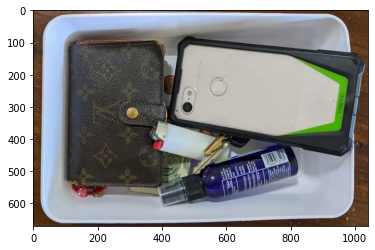

In [16]:
file_name = "lighter_test_set_1of5.jpg"
with open(os.path.join (local_image_path, file_name), 'rb') as img_code:
    img_view_ready = Image.open(img_code)
    plt.figure()
    plt.imshow(img_view_ready)

0.7596083
	Lighter: 75.96%
	Lighter: 13.95%
	Lighter: 11.48%
	Lighter: 8.74%
	Lighter: 7.81%
	Lighter: 5.03%
	Lighter: 4.06%
	Lighter: 3.96%
	Lighter: 3.62%
	Lighter: 3.58%
	Lighter: 3.56%
	Lighter: 2.54%
	Lighter: 2.39%
	Lighter: 2.25%
	Lighter: 2.25%
	Lighter: 1.65%
	Lighter: 1.50%
	Lighter: 1.43%
	Lighter: 1.26%
	Lighter: 1.10%
	Lighter: 1.01%
	Lighter: 0.96%
	Lighter: 0.95%
	Lighter: 0.93%
	Lighter: 0.83%
	Lighter: 0.82%
	Lighter: 0.80%
	Lighter: 0.79%
	Lighter: 0.74%
	Lighter: 0.71%
	Lighter: 0.62%
	Lighter: 0.60%
	Lighter: 0.56%
	Lighter: 0.55%


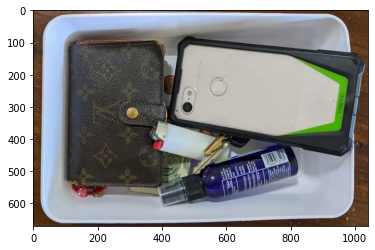

In [26]:
file_name = "lighter_test_set_1of5.jpg"
perform_prediction(local_image_path, file_name)
## Checking the Image
with open(local_image_path + "/" + file_name, 'rb') as img_code:
    img_view_ready = Image.open(img_code)
    plt.figure()
    plt.imshow(img_view_ready)

### Exporting Model

In [7]:
platform = "TensorFlow"
flavor = "TensorFlowNormal"
export_process = trainer.export_iteration(project_id, iteration_id, platform, flavor, raw=True)

In [13]:
print(export_process.output)

{'additional_properties': {}, 'platform': 'TensorFlow', 'status': 'Exporting', 'download_uri': None, 'flavor': None, 'newer_version_available': False}


In [14]:
print(export_process.output.status)

Exporting


In [31]:
### Code snippet is from Azure SDK and Documentation
### https://docs.microsoft.com/en-us/azure/cognitive-services/custom-vision-service/export-programmatically
### This step may take long time 
while (export_process.output.status == "Exporting"):
    print ("Waiting 10 seconds...")
    time.sleep(10)
    exports = trainer.get_exports(project_id, iteration_id)
    for e in exports:
        if e.platform == export_process.output.platform and e.flavor == export_process.output.flavor:
            export = e
            break
    print("Export status is: ", export_process.output.status)

Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export st

: 

: 

In [16]:
## Downloading the model from url
if export_process.output.status == "Done":
    # Ready to Download
    model_export_file = requests.get(export_process.output.download_uri)
    with open("object_detection_model.zip", "wb") as file:
        file.write(model_export_file.content)